<a href="https://colab.research.google.com/github/lorenzrossi/AMD-ComicsFaces/blob/main/Complete_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2
import zipfile

#from google.colab import drive
#drive.mount('/content/drive')

from google.colab import files

uploaded = files.upload()

# UPLOAD YOUR KAGGLE API KEY

for fn in uploaded.keys():
  print('key "{name}"'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#dir = '/content/drive/MyDrive/ComicsFaces'

#X = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/X.pickle','rb'))
#y = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/y.pickle','rb'))


Saving kaggle.json to kaggle.json
key "kaggle.json"


In [2]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
# usare il link di kaggle per scaricare le immagini

!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2

 99% 2.16G/2.18G [00:12<00:00, 218MB/s]
100% 2.18G/2.18G [00:12<00:00, 189MB/s]


In [4]:
with zipfile.ZipFile('comic-faces-paired-synthetic-v2.zip','r') as zipref:
     zipref.extractall()
!rm -rf /content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

In [5]:
dir = "/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"


# I define some parameters in order resize image in an uniform way and I set 3 as number of channels of the image, since I want RGB images
img_width = 100
img_height = 100
img_size = (img_width, img_height)

# Pets is the list in which alle the images will be stored
pics = []

# I define the two categories of pics ( related to the sub-directories of comics and faces)
categories = ['comics','faces']

# I create a funciotn in order to load the data, transform the into array, assign them to a class and store them in the pics list
def create_data():

# the function iterates throught the two sub-directories
    for category in categories:
        path = os.path.join(dir, category)

# assign 0 to comics and 1 to faces, according to the index of the categories
        pic_class = categories.index(category)

# the function then iterates through each image in both the folders. I used the opencv (cv2 when imported) package to read and load them. IMREAD_COLOR keeps the color in the image, whereas IMREAD_GRAYSCALE would turn them into grayscale images.
# The function resize the images as defined by the previous parameters and finally appends the array of the image, together with the class value (creating a sub-list of two values for each image), to the pets list.
# The function skips those images which seem broken.
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, img_size)
                pics.append([new_array, pic_class])
            except Exception as e:
                pass

create_data()

print(len(pics))

# since the previous function iterates linearly through the two sub-directories, I shuffle the data in order to mix shuffle the order of the images
random.shuffle(pics)

for sample in pics[:9]:
    print(sample[1])

20000
0
1
1
1
1
0
1
0
1


In [6]:
# split the data arrays and the labels for the classification task

X = []
y = []

for image, label in pics:
    X.append(image)
    y.append(label)

X = np.array(X).reshape(-1, img_width, img_height, 1)

In [7]:
# Now import all the packages for NN, hyperparameters and data processing 

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tfk = tf.keras
tf.keras.backend.set_floatx("float64")

from sklearn.model_selection import train_test_split

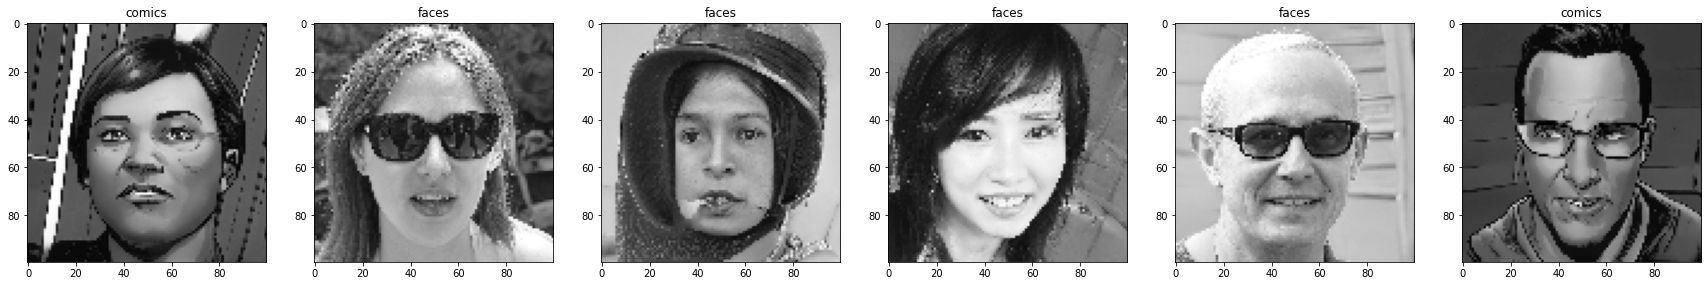

In [8]:
pics_classes = ['comics','faces']

images_to_plot = 6
     

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

gray_channel = 0

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pics_classes[numeric_label])

In [9]:
number_of_classes = len(pics_classes)    

x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])
     

# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [10]:
# Hyperparameters
epoch = 25 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
#op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/25)

In [11]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','test'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# BASE ARCHITECTURE

## Model 1

In [12]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 128)               10240000  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

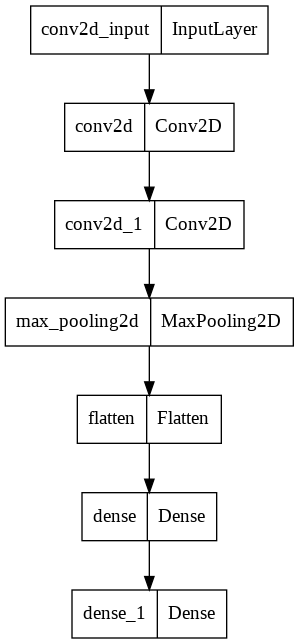

In [13]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/25
200/200 [==============================] - 13s 21ms/step - loss: 0.0490 - binary_accuracy: 0.9789 - val_loss: 0.0090 - val_binary_accuracy: 0.9962
Epoch 2/25
200/200 [==============================] - 4s 20ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.0128 - val_binary_accuracy: 0.9966
Epoch 3/25
200/200 [==============================] - 4s 20ms/step - loss: 5.0709e-04 - binary_accuracy: 0.9999 - val_loss: 0.0047 - val_binary_accuracy: 0.9988
Epoch 4/25
200/200 [==============================] - 4s 20ms/step - loss: 9.4856e-05 - binary_accuracy: 1.0000 - val_loss: 0.0063 - val_binary_accuracy: 0.9988
Epoch 5/25
200/200 [==============================] - 4s 20ms/step - loss: 5.5170e-05 - binary_accuracy: 1.0000 - val_loss: 0.0050 - val_binary_accuracy: 0.9988
Epoch 6/25
200/200 [==============================] - 4s 20ms/step - loss: 3.0966e-05 - binary_accuracy: 1.0000 - val_loss: 0.0053 - val_binary_accuracy: 0.9991
Epoch 7/25
200/200 [=====================

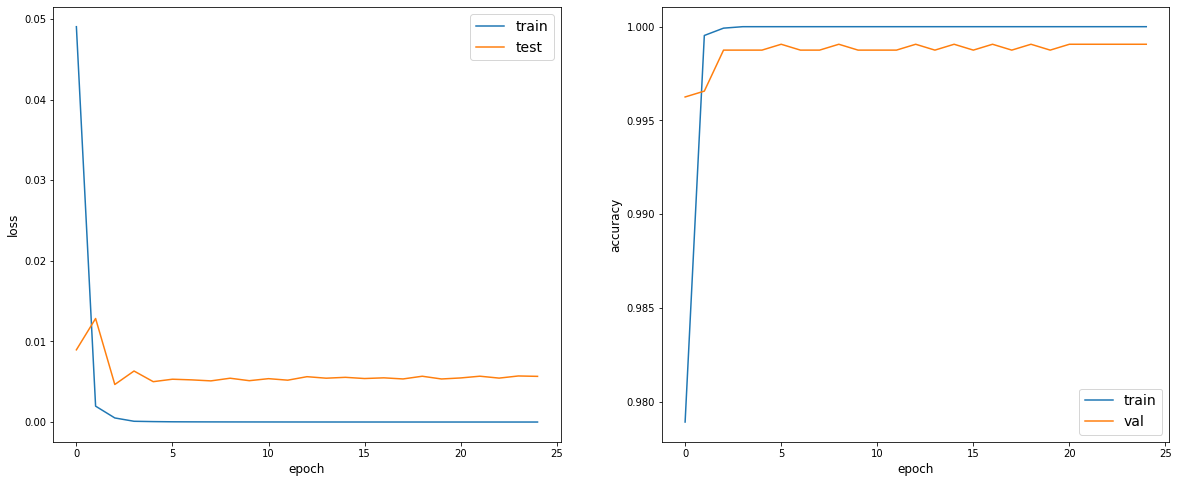

125/125 [==============================] - 1s 6ms/step - loss: 0.0040 - binary_accuracy: 0.9992
test loss, test acc: [0.00397786781722675, 0.99925]


In [14]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [15]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)            

Epoch 1/25
200/200 [==============================] - 6s 24ms/step - loss: 0.0899 - binary_accuracy: 0.9630 - val_loss: 0.0067 - val_binary_accuracy: 0.9988
Epoch 2/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0031 - binary_accuracy: 0.9988 - val_loss: 0.0058 - val_binary_accuracy: 0.9988
Epoch 3/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0011 - binary_accuracy: 0.9995 - val_loss: 0.0078 - val_binary_accuracy: 0.9988
Epoch 4/25
200/200 [==============================] - 5s 24ms/step - loss: 6.8370e-04 - binary_accuracy: 0.9998 - val_loss: 0.0111 - val_binary_accuracy: 0.9981
Epoch 5/25
200/200 [==============================] - 5s 24ms/step - loss: 4.5781e-04 - binary_accuracy: 0.9998 - val_loss: 0.0126 - val_binary_accuracy: 0.9984
Epoch 6/25
200/200 [==============================] - 5s 24ms/step - loss: 1.4605e-04 - binary_accuracy: 1.0000 - val_loss: 0.0091 - val_binary_accuracy: 0.9988
Epoch 7/25
200/200 [==========================

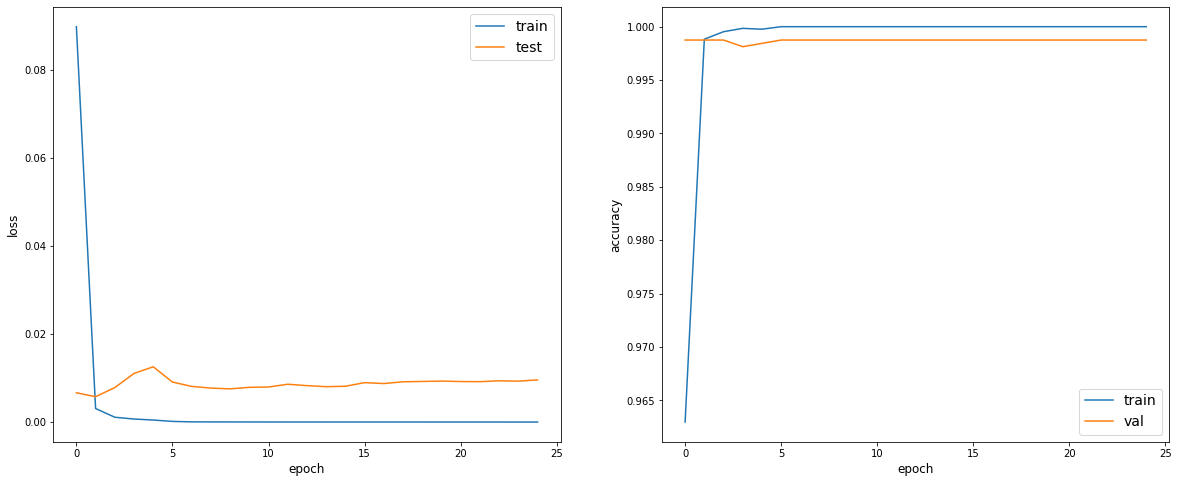

125/125 [==============================] - 1s 7ms/step - loss: 0.0034 - binary_accuracy: 0.9990
test loss, test acc: [0.0033761486135428847, 0.999]


In [16]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

# Model 3

In [17]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 128)      

Epoch 1/25
200/200 [==============================] - 6s 28ms/step - loss: 0.1592 - binary_accuracy: 0.9201 - val_loss: 0.0108 - val_binary_accuracy: 0.9969
Epoch 2/25
200/200 [==============================] - 5s 27ms/step - loss: 0.0092 - binary_accuracy: 0.9970 - val_loss: 0.0060 - val_binary_accuracy: 0.9984
Epoch 3/25
200/200 [==============================] - 5s 27ms/step - loss: 0.0041 - binary_accuracy: 0.9988 - val_loss: 0.0048 - val_binary_accuracy: 0.9981
Epoch 4/25
200/200 [==============================] - 5s 27ms/step - loss: 0.0034 - binary_accuracy: 0.9987 - val_loss: 0.0051 - val_binary_accuracy: 0.9991
Epoch 5/25
200/200 [==============================] - 5s 27ms/step - loss: 0.0023 - binary_accuracy: 0.9990 - val_loss: 0.0038 - val_binary_accuracy: 0.9988
Epoch 6/25
200/200 [==============================] - 5s 27ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - val_loss: 0.0047 - val_binary_accuracy: 0.9991
Epoch 7/25
200/200 [==============================] - 5s 2

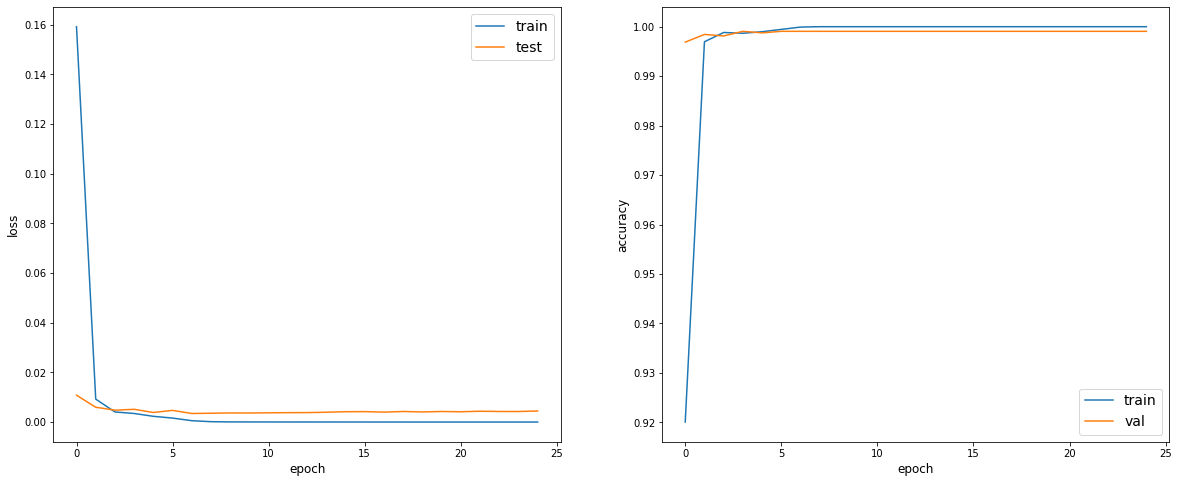

125/125 [==============================] - 1s 7ms/step - loss: 0.0034 - binary_accuracy: 0.9992
test loss, test acc: [0.003448245342896244, 0.99925]


In [18]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING DROPOUT LAYERS

# Model 1

In [19]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 80000)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               10240000  
                                                      

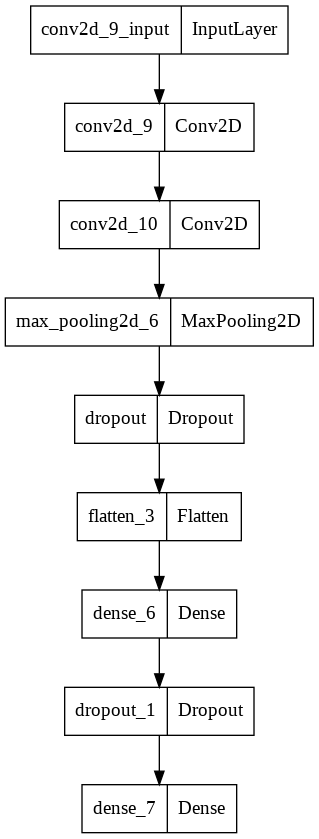

In [20]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/25
200/200 [==============================] - 5s 21ms/step - loss: 0.0934 - binary_accuracy: 0.9716 - val_loss: 0.0126 - val_binary_accuracy: 0.9966
Epoch 2/25
200/200 [==============================] - 4s 20ms/step - loss: 0.0042 - binary_accuracy: 0.9992 - val_loss: 0.0065 - val_binary_accuracy: 0.9981
Epoch 3/25
200/200 [==============================] - 4s 20ms/step - loss: 0.0013 - binary_accuracy: 0.9997 - val_loss: 0.0079 - val_binary_accuracy: 0.9981
Epoch 4/25
200/200 [==============================] - 4s 20ms/step - loss: 5.0810e-04 - binary_accuracy: 0.9999 - val_loss: 0.0084 - val_binary_accuracy: 0.9981
Epoch 5/25
200/200 [==============================] - 4s 20ms/step - loss: 9.3094e-05 - binary_accuracy: 1.0000 - val_loss: 0.0098 - val_binary_accuracy: 0.9981
Epoch 6/25
200/200 [==============================] - 4s 20ms/step - loss: 1.1256e-04 - binary_accuracy: 1.0000 - val_loss: 0.0094 - val_binary_accuracy: 0.9981
Epoch 7/25
200/200 [==========================

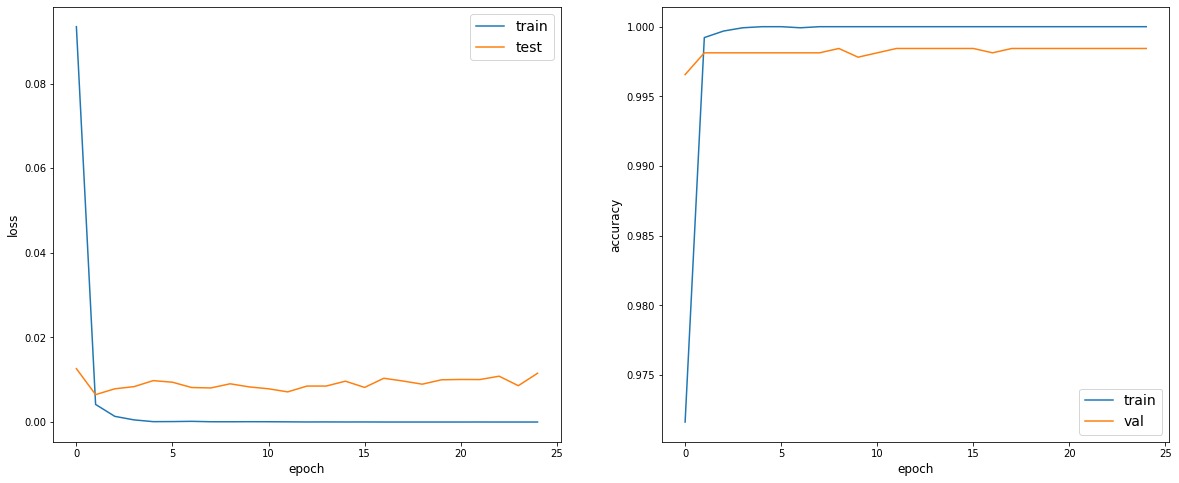

125/125 [==============================] - 1s 6ms/step - loss: 0.0026 - binary_accuracy: 0.9988
test loss, test acc: [0.0025807538746869707, 0.99875]


In [21]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [22]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

Epoch 1/25
200/200 [==============================] - 6s 25ms/step - loss: 0.1401 - binary_accuracy: 0.9457 - val_loss: 0.0085 - val_binary_accuracy: 0.9975
Epoch 2/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0100 - binary_accuracy: 0.9976 - val_loss: 0.0198 - val_binary_accuracy: 0.9934
Epoch 3/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0066 - binary_accuracy: 0.9978 - val_loss: 0.0070 - val_binary_accuracy: 0.9988
Epoch 4/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 0.0052 - val_binary_accuracy: 0.9984
Epoch 5/25
200/200 [==============================] - 5s 25ms/step - loss: 0.0026 - binary_accuracy: 0.9994 - val_loss: 0.0071 - val_binary_accuracy: 0.9988
Epoch 6/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0035 - binary_accuracy: 0.9990 - val_loss: 0.0088 - val_binary_accuracy: 0.9988
Epoch 7/25
200/200 [==============================] - 5s 2

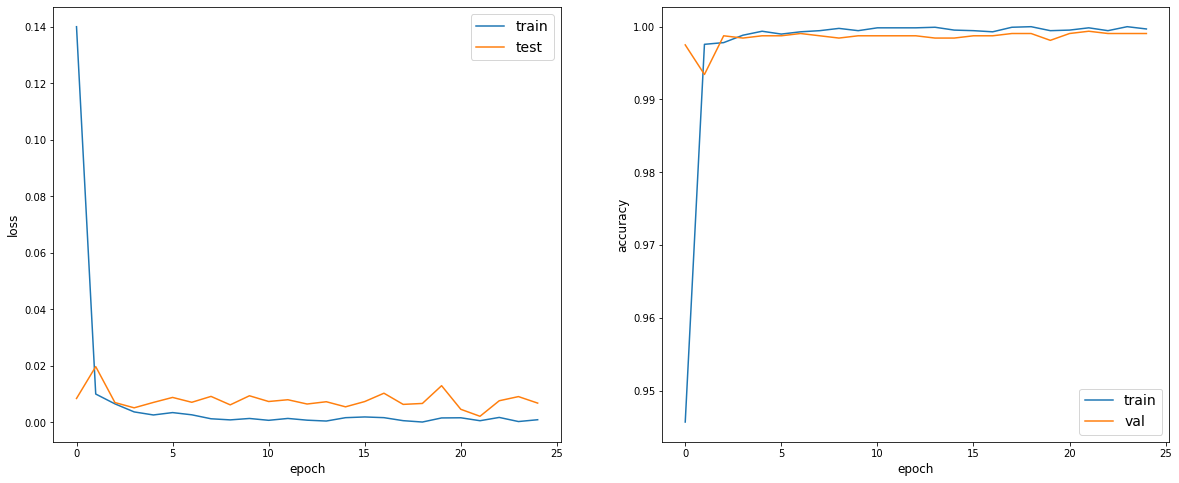

125/125 [==============================] - 1s 7ms/step - loss: 0.0031 - binary_accuracy: 0.9990
test loss, test acc: [0.0030833298856232524, 0.999]


In [23]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [24]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 conv2d_15 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 64)        18432     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                 

Epoch 1/25
200/200 [==============================] - 6s 28ms/step - loss: 0.2179 - binary_accuracy: 0.9072 - val_loss: 0.0147 - val_binary_accuracy: 0.9966
Epoch 2/25
200/200 [==============================] - 6s 28ms/step - loss: 0.0206 - binary_accuracy: 0.9923 - val_loss: 0.0175 - val_binary_accuracy: 0.9934
Epoch 3/25
200/200 [==============================] - 6s 28ms/step - loss: 0.0137 - binary_accuracy: 0.9953 - val_loss: 0.0075 - val_binary_accuracy: 0.9978
Epoch 4/25
200/200 [==============================] - 6s 28ms/step - loss: 0.0103 - binary_accuracy: 0.9970 - val_loss: 0.0049 - val_binary_accuracy: 0.9988
Epoch 5/25
200/200 [==============================] - 6s 28ms/step - loss: 0.0076 - binary_accuracy: 0.9977 - val_loss: 0.0062 - val_binary_accuracy: 0.9981
Epoch 6/25
200/200 [==============================] - 6s 28ms/step - loss: 0.0055 - binary_accuracy: 0.9982 - val_loss: 0.0043 - val_binary_accuracy: 0.9994
Epoch 7/25
200/200 [==============================] - 6s 2

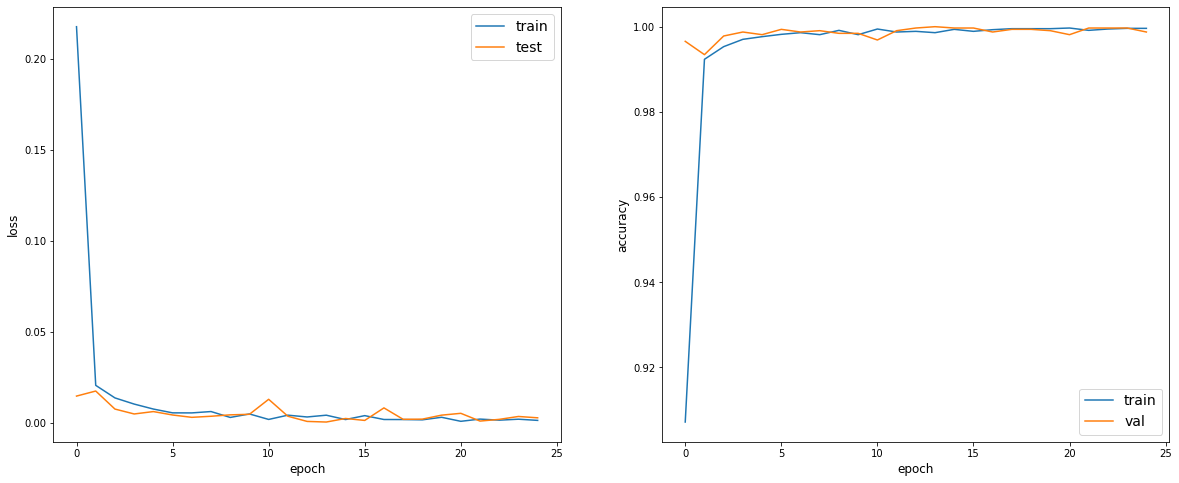

125/125 [==============================] - 1s 7ms/step - loss: 0.0017 - binary_accuracy: 0.9992
test loss, test acc: [0.0016968679259978597, 0.99925]


In [25]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING BATCH NORMALIZATION LAYERS

## Model 1

In [26]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

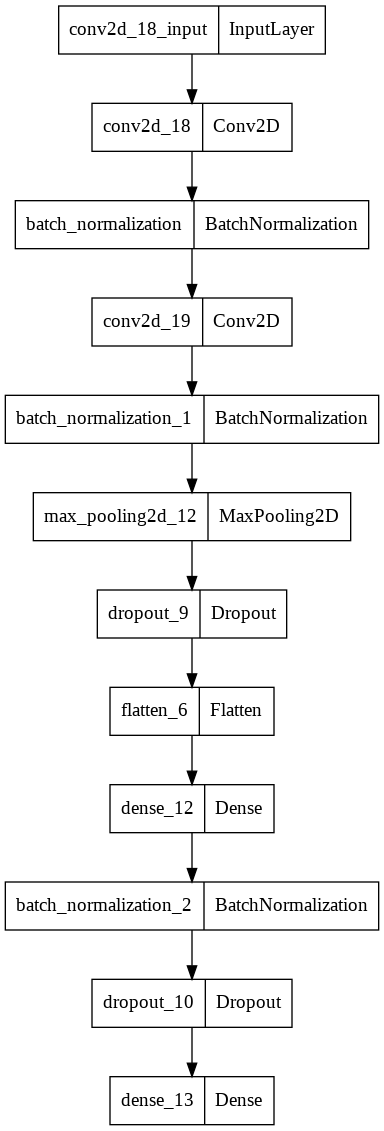

In [27]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/25
200/200 [==============================] - 8s 34ms/step - loss: 0.0272 - binary_accuracy: 0.9898 - val_loss: 1.9404 - val_binary_accuracy: 0.4947
Epoch 2/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0029 - binary_accuracy: 0.9993 - val_loss: 0.6924 - val_binary_accuracy: 0.6659
Epoch 3/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0021 - binary_accuracy: 0.9996 - val_loss: 0.0040 - val_binary_accuracy: 0.9994
Epoch 4/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0016 - binary_accuracy: 0.9997 - val_loss: 0.0046 - val_binary_accuracy: 0.9981
Epoch 5/25
200/200 [==============================] - 7s 33ms/step - loss: 8.8304e-04 - binary_accuracy: 0.9997 - val_loss: 8.6157e-04 - val_binary_accuracy: 1.0000
Epoch 6/25
200/200 [==============================] - 7s 33ms/step - loss: 0.0017 - binary_accuracy: 0.9993 - val_loss: 0.0014 - val_binary_accuracy: 0.9997
Epoch 7/25
200/200 [==============================

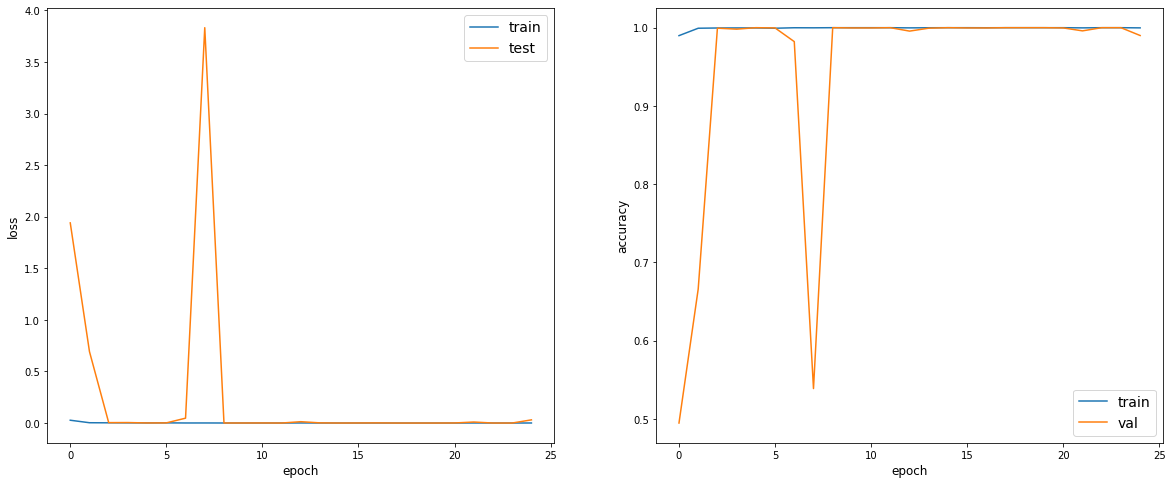

125/125 [==============================] - 1s 7ms/step - loss: 0.0306 - binary_accuracy: 0.9908
test loss, test acc: [0.030640632423400933, 0.99075]


In [28]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [29]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_4 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

Epoch 1/25
200/200 [==============================] - 10s 42ms/step - loss: 0.0204 - binary_accuracy: 0.9926 - val_loss: 1.0700 - val_binary_accuracy: 0.4950
Epoch 2/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0029 - binary_accuracy: 0.9993 - val_loss: 3.7599 - val_binary_accuracy: 0.5100
Epoch 3/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0021 - binary_accuracy: 0.9997 - val_loss: 0.0060 - val_binary_accuracy: 0.9981
Epoch 4/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0016 - binary_accuracy: 0.9996 - val_loss: 0.4448 - val_binary_accuracy: 0.9841
Epoch 5/25
200/200 [==============================] - 8s 40ms/step - loss: 0.0011 - binary_accuracy: 0.9995 - val_loss: 0.4392 - val_binary_accuracy: 0.9894
Epoch 6/25
200/200 [==============================] - 8s 40ms/step - loss: 4.4929e-04 - binary_accuracy: 1.0000 - val_loss: 0.0098 - val_binary_accuracy: 0.9997
Epoch 7/25
200/200 [==============================] -

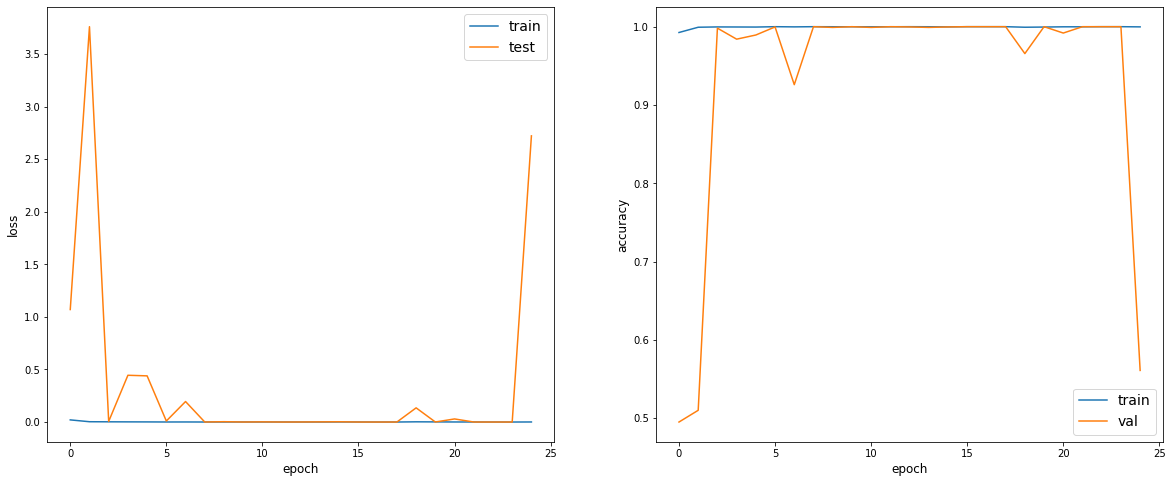

125/125 [==============================] - 1s 8ms/step - loss: 2.5469 - binary_accuracy: 0.5760
test loss, test acc: [2.5469054077001365, 0.576]


In [30]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [31]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_7 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_24 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

Epoch 1/25
200/200 [==============================] - 10s 46ms/step - loss: 0.0184 - binary_accuracy: 0.9930 - val_loss: 3.9789 - val_binary_accuracy: 0.4947
Epoch 2/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0028 - binary_accuracy: 0.9991 - val_loss: 1.4357 - val_binary_accuracy: 0.4988
Epoch 3/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0027 - binary_accuracy: 0.9993 - val_loss: 0.3661 - val_binary_accuracy: 0.8662
Epoch 4/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0013 - binary_accuracy: 0.9997 - val_loss: 0.0087 - val_binary_accuracy: 0.9978
Epoch 5/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0013 - binary_accuracy: 0.9995 - val_loss: 9.4250e-04 - val_binary_accuracy: 0.9997
Epoch 6/25
200/200 [==============================] - 9s 45ms/step - loss: 4.6024e-04 - binary_accuracy: 0.9999 - val_loss: 0.0913 - val_binary_accuracy: 0.9947
Epoch 7/25
200/200 [=============================

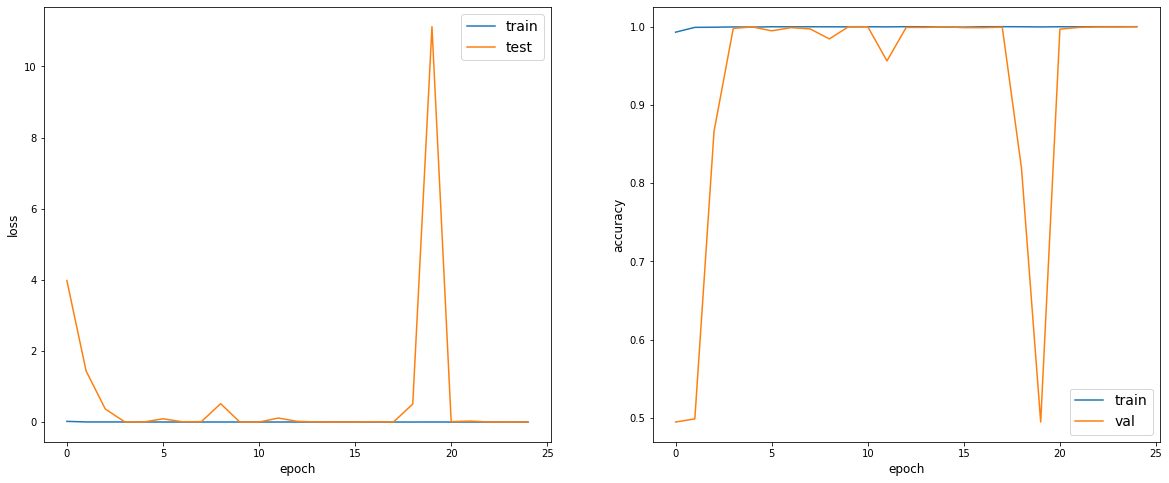

125/125 [==============================] - 1s 8ms/step - loss: 0.0016 - binary_accuracy: 0.9998
test loss, test acc: [0.0015839715575588157, 0.99975]


In [32]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)

# ADDING ADDITIONAL DENSE LAYER

## Model 1

In [33]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(256, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_12 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_13 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                      

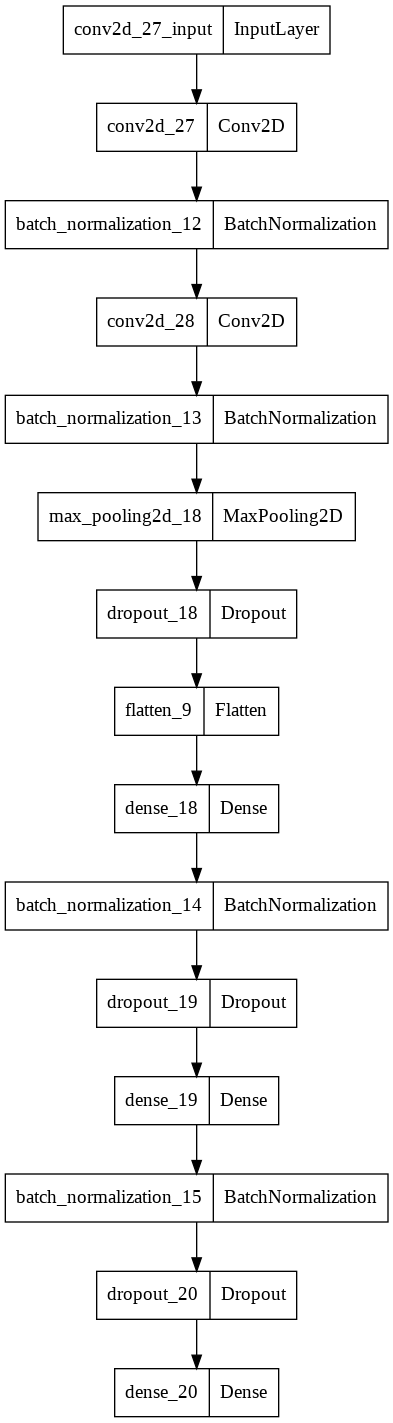

In [34]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/25
200/200 [==============================] - 8s 35ms/step - loss: 0.0302 - binary_accuracy: 0.9894 - val_loss: 16.5652 - val_binary_accuracy: 0.4947
Epoch 2/25
200/200 [==============================] - 7s 34ms/step - loss: 0.0035 - binary_accuracy: 0.9990 - val_loss: 0.5849 - val_binary_accuracy: 0.7334
Epoch 3/25
200/200 [==============================] - 7s 34ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - val_loss: 0.0102 - val_binary_accuracy: 0.9975
Epoch 4/25
200/200 [==============================] - 7s 34ms/step - loss: 9.5206e-04 - binary_accuracy: 0.9998 - val_loss: 0.0011 - val_binary_accuracy: 0.9997
Epoch 5/25
200/200 [==============================] - 7s 34ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - val_loss: 0.0063 - val_binary_accuracy: 0.9981
Epoch 6/25
200/200 [==============================] - 7s 34ms/step - loss: 4.7554e-04 - binary_accuracy: 0.9999 - val_loss: 0.0010 - val_binary_accuracy: 0.9994
Epoch 7/25
200/200 [=============================

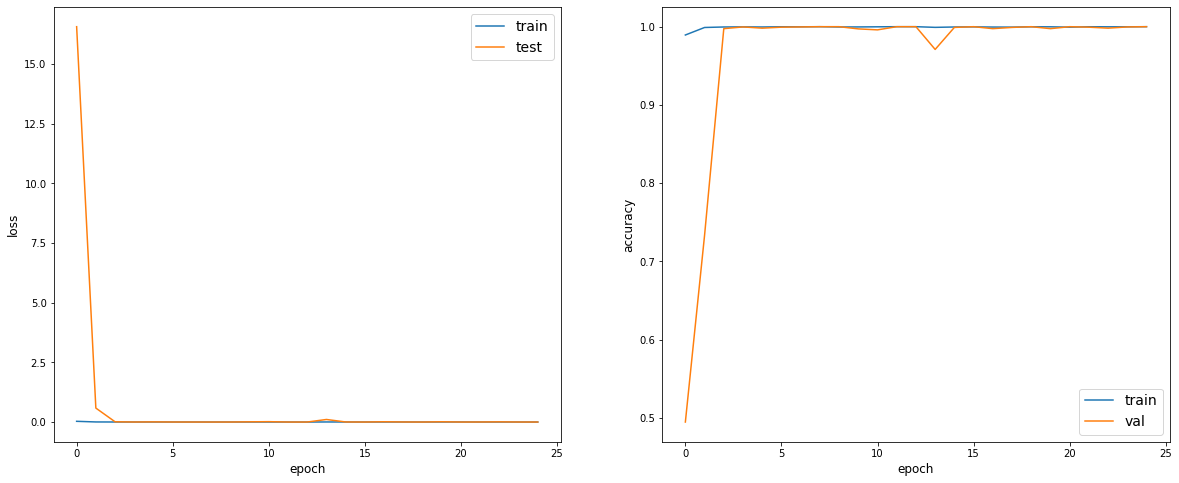

125/125 [==============================] - 1s 7ms/step - loss: 1.0142e-05 - binary_accuracy: 1.0000
test loss, test acc: [1.0141672838499529e-05, 1.0]


In [35]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

## Model 2

In [36]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_16 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_30 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_17 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/25
200/200 [==============================] - 10s 42ms/step - loss: 0.0245 - binary_accuracy: 0.9909 - val_loss: 5.5539 - val_binary_accuracy: 0.4947
Epoch 2/25
200/200 [==============================] - 8s 41ms/step - loss: 0.0049 - binary_accuracy: 0.9982 - val_loss: 4.4586 - val_binary_accuracy: 0.4947
Epoch 3/25
200/200 [==============================] - 8s 41ms/step - loss: 0.0035 - binary_accuracy: 0.9989 - val_loss: 0.5179 - val_binary_accuracy: 0.7809
Epoch 4/25
200/200 [==============================] - 8s 41ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - val_loss: 0.0014 - val_binary_accuracy: 0.9994
Epoch 5/25
200/200 [==============================] - 8s 41ms/step - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 0.0018 - val_binary_accuracy: 0.9994
Epoch 6/25
200/200 [==============================] - 8s 41ms/step - loss: 4.2587e-04 - binary_accuracy: 0.9999 - val_loss: 6.5133e-04 - val_binary_accuracy: 0.9997
Epoch 7/25
200/200 [=============================

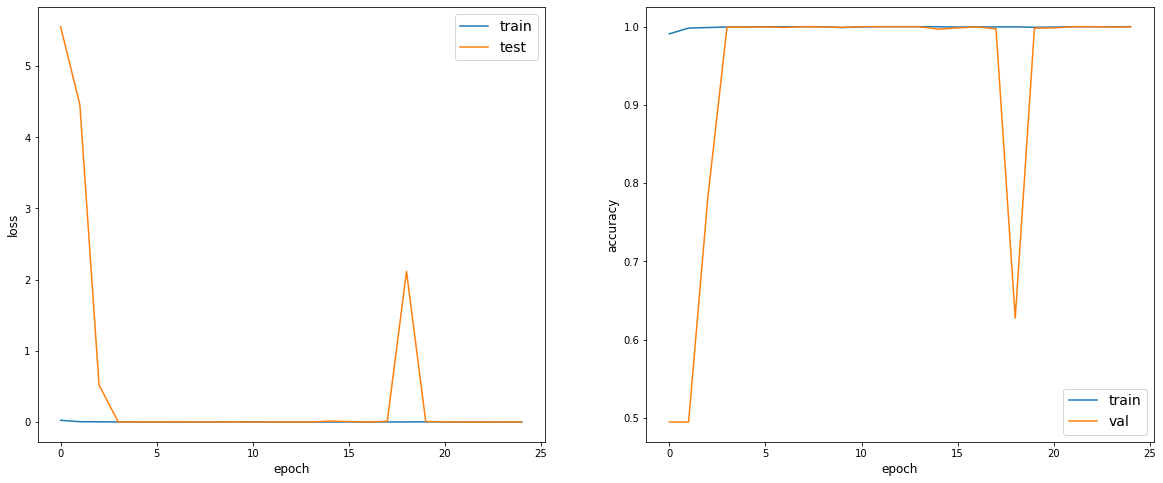

125/125 [==============================] - 1s 8ms/step - loss: 1.5499e-05 - binary_accuracy: 1.0000
test loss, test acc: [1.5498857682340046e-05, 1.0]


In [37]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

## Model 3

In [38]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_21 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_22 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                     

Epoch 1/25
200/200 [==============================] - 11s 47ms/step - loss: 0.0255 - binary_accuracy: 0.9905 - val_loss: 5.0521 - val_binary_accuracy: 0.4947
Epoch 2/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0048 - binary_accuracy: 0.9988 - val_loss: 2.2514 - val_binary_accuracy: 0.4947
Epoch 3/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0030 - binary_accuracy: 0.9991 - val_loss: 0.0647 - val_binary_accuracy: 0.9816
Epoch 4/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0026 - binary_accuracy: 0.9991 - val_loss: 0.0125 - val_binary_accuracy: 0.9962
Epoch 5/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0030 - binary_accuracy: 0.9990 - val_loss: 0.0324 - val_binary_accuracy: 0.9969
Epoch 6/25
200/200 [==============================] - 9s 45ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - val_loss: 0.0163 - val_binary_accuracy: 0.9978
Epoch 7/25
200/200 [==============================] - 9s 

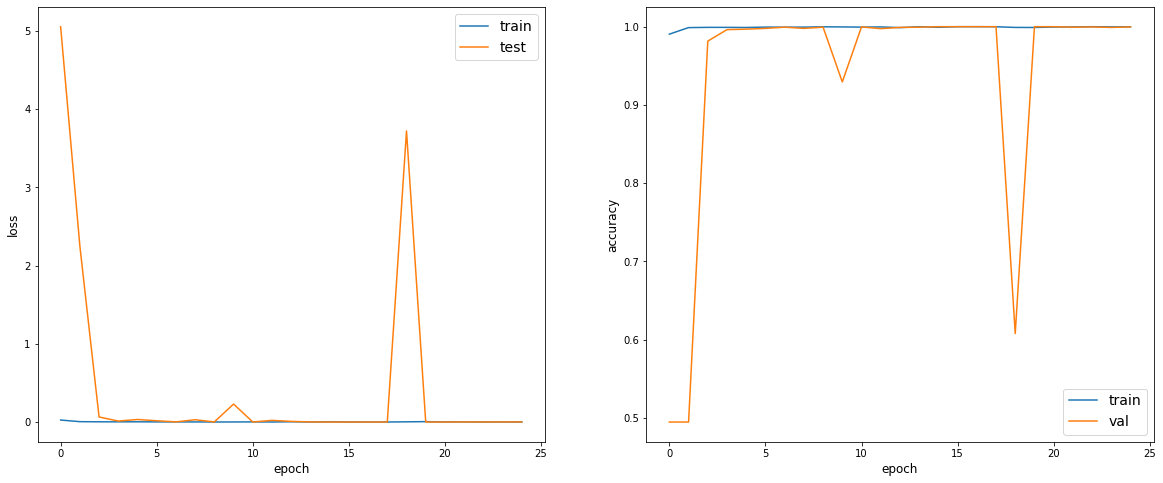

125/125 [==============================] - 1s 8ms/step - loss: 0.0051 - binary_accuracy: 0.9995
test loss, test acc: [0.005081722412097542, 0.9995]


In [39]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)